# LSTM.

We are doing time series forecasting on pakistani data set using LSTM

In [ ]:
# Mount thee google drive.
from google.colab import drive
drive.mount('/content/drive')

In [9]:
# Importing all necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Igorning warnings.
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning

In [11]:
# loading the data.
data2 = pd.read_csv('/content/drive/MyDrive/E-commerce_FBprophet/Final.csv')
data2.head()

,Unnamed: 0,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,...,order_item_id,seller_id,shipping_limit_date,price,freight_value,zip_code_prefix_y,seller_city,seller_state,geolocation_lat_y,geolocation_lng_y
0,200,3b697a20d9e427646d92567910af6d57,1,boleto,1,45.46,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,...,1,522620dcb18a6b31cd7bdf73665113a9,2016-10-21 16:27:20,29.90,15.56,85801,cascavel,PR,-24.961401,-53.458166
1,33797,be5bc2f0da14d8071e2d45451ad119d9,1,boleto,1,39.09,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,...,1,f09b760d23495ac9a7e00d29b769007c,2016-10-21 16:33:46,21.90,17.19,15802,catanduva,SP,-21.142131,-48.989022
2,2464,a41c8759fbe7aab36ea07e038b2d4465,1,boleto,1,53.73,6f989332712d3222b6571b1cf5b835ce,delivered,2016-10-03 21:13:36,2016-10-05 03:11:49,...,1,45d33f715e24d15a6ccf5c17b3a23e3c,2016-10-21 16:18:26,36.49,17.24,18015,sorocaba,SP,-23.496367,-47.438900
3,49415,d207cc272675637bfed0062edffd0818,1,credit_card,6,133.46,b8cf418e97ae795672d326288dfab7a7,delivered,2016-10-03 22:06:03,2016-10-04 10:28:07,...,1,cca3071e3e9bb7d12640c9fbe2301306,2016-10-21 16:23:06,119.90,13.56,14940,ibitinga,SP,-21.766477,-48.831547
4,55468,cd3b8574c82b42fc8129f6d502690c3e,1,credit_card,4,40.95,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03 22:31:31,2016-10-04 10:19:23,...,1,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,29.99,10.96,13481,limeira,SP,-22.599254,-47.379810


In [12]:
# Only taking necessary columns for orders forcasting.
df = data2[['order_purchase_timestamp','order_id']]
df.head()

,order_purchase_timestamp,order_id
0,2016-10-03 09:44:50,3b697a20d9e427646d92567910af6d57
1,2016-10-03 16:56:50,be5bc2f0da14d8071e2d45451ad119d9
2,2016-10-03 21:13:36,a41c8759fbe7aab36ea07e038b2d4465
3,2016-10-03 22:06:03,d207cc272675637bfed0062edffd0818
4,2016-10-03 22:31:31,cd3b8574c82b42fc8129f6d502690c3e


In [13]:
# Extracting only date from datetime and total count of orders
df.order_purchase_timestamp = pd.to_datetime(df.order_purchase_timestamp).dt.date
# sort the index values.
df = df.sort_values('order_purchase_timestamp')
df

,order_purchase_timestamp,order_id
0,2016-10-03,3b697a20d9e427646d92567910af6d57
1,2016-10-03,be5bc2f0da14d8071e2d45451ad119d9
2,2016-10-03,a41c8759fbe7aab36ea07e038b2d4465
3,2016-10-03,d207cc272675637bfed0062edffd0818
4,2016-10-03,cd3b8574c82b42fc8129f6d502690c3e
...,...,...
112638,2018-08-29,bee12e8653a04e76786e8891cfb6330a
112637,2018-08-29,c84d88553f9878bf2c7ecda2eb211ece
112651,2018-08-29,03ef5dedbe7492bdae72eec50764c43f
112643,2018-08-29,fb393211459aac00af932cd7ab4fa2cc


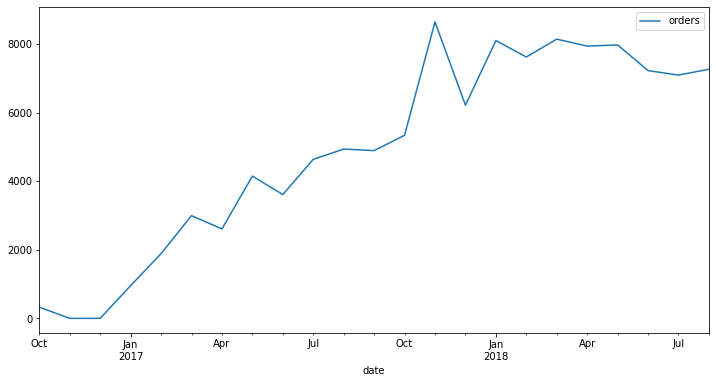

In [14]:
# resetting the index as date.
df = df.groupby('order_purchase_timestamp')['order_id'].count().reset_index()
# Renaming the columns.
df.rename(columns={'order_purchase_timestamp':'date', 'order_id':'orders'}, inplace=True)
df.set_index('date', inplace=True)
# Converting daily data into monthly for further processing.
df.index = pd.to_datetime(df.index)
# resampling data monthly.
df = df.resample('M').sum()
# Plotting the dataset.
df.plot(figsize=(12,6))

# Train test split

In [19]:
# print len
print(len(df))
# Split data into train and test.
train = df.iloc[:18]
test = df.iloc[18:]
# scaling of data.
scalar = MinMaxScaler()
# Fitting the data.
scalar.fit(train)
scaled_train = scalar.transform(train)
scaled_test = scalar.transform(test)

23


In [20]:
# Importing timeseries generator to generate a sequence of data for forecasting.
from keras.preprocessing.sequence import TimeseriesGenerator

# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03790593 0.         0.00011557]
Predict this y: 
 [[0.11036635]]


In [21]:
# We do the same thing, but now instead for 6 months.
n_input = 6
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

### Model Building.

In [31]:
# Importing libraries.
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [22]:
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model
model.fit(generator,epochs=42)

Epoch 1/42
12/12 [==============================] - 3s 7ms/step - loss: 0.4483
Epoch 2/42
12/12 [==============================] - 0s 7ms/step - loss: 0.3342
Epoch 3/42
12/12 [==============================] - 0s 6ms/step - loss: 0.1878
Epoch 4/42
12/12 [==============================] - 0s 7ms/step - loss: 0.0372
Epoch 5/42
12/12 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 6/42
12/12 [==============================] - 0s 7ms/step - loss: 0.0211
Epoch 7/42
12/12 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 8/42
12/12 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 9/42
12/12 [==============================] - 0s 6ms/step - loss: 0.0151
Epoch 10/42
12/12 [==============================] - 0s 7ms/step - loss: 0.0150
Epoch 11/42
12/12 [==============================] - 0s 6ms/step - loss: 0.0251
Epoch 12/42
12/12 [==============================] - 0s 7ms/step - loss: 0.0187
Epoch 13/42
12/12 [==============================

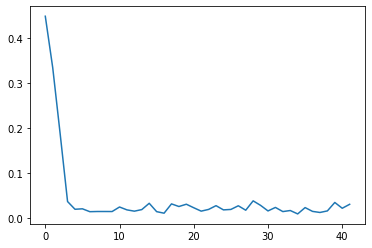

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
last_train_batch = scaled_train[-6:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 0s 332ms/step


array([[0.8732325]], dtype=float32)

In [26]:
# Prediction on last test data.

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [27]:
test_predictions

[array([0.8732325], dtype=float32),
 array([0.93481255], dtype=float32),
 array([0.9105372], dtype=float32),
 array([0.95503175], dtype=float32),
 array([0.95124376], dtype=float32)]

            orders  Predictions
date                           
2018-04-30    7946  7556.080683
2018-05-31    7980  8088.932959
2018-06-30    7230  7878.878247
2018-07-31    7100  8263.889755
2018-08-31    7270  8231.112240


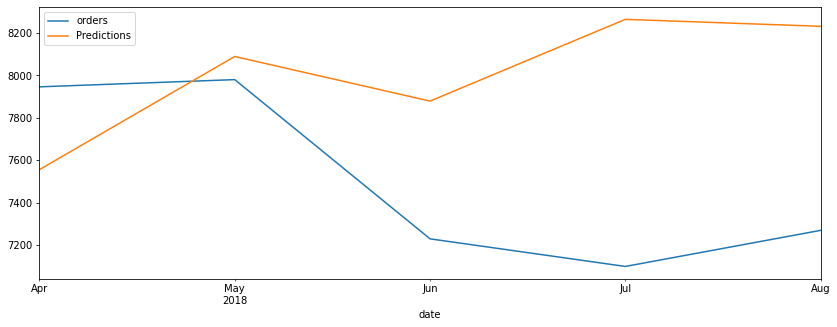

In [30]:
# using inverse transform to get the original values.
true_predictions = scalar.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
print(test.head())
# plotting the actual and predicted values.
test.plot(figsize=(14,5))

So theses are the actual and predicted order values we get from the LSTM.